# Face Generation using Pytorch Pre-trained Model

Pytorch Hub is a pre-trained model repository designed to facilitate research reproducibility. 

Using TorchNet in Analytics-Zoo, we can easily load these pre-trained model and make distributed inference with only a few lines of code change.

Here is an easy example to load Pytorch pretrained [Progressive Growing of GANs (PGAN)](https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_pgan/) from Pytorch Hub to Analytics-Zoo, and generate faces in distributed mode on Spark. We just make a little change of the pytorch prediction example code in sector 1.

## 1. Pytorch's example
This sector will show you how pytorch run the generation. The code in this sector is copied from [PGAN](https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_pgan/).  
The next sector will show you how to run a distributed generation using Analytics-Zoo and Spark.

### Load pretrained model from Pytorch Hub
Load [PGAN](https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_pgan/) from Pytorch Hub.
This PGAM model trained on high-quality celebrity faces "celebA" dataset, and will outputs 512 x 512 pixel images

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

In [3]:
import torch

model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=False)

Using cache found in /home/xin/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


### Generate noise with model's build-in method

In [4]:
num_images = 64
noise, _ = model.buildNoiseData(num_images)

### Run Generation in Pytorch

In [5]:
%%time
global generated_images
with torch.no_grad():
    generated_images = model.test(noise)

CPU times: user 1min 17s, sys: 17 s, total: 1min 34s
Wall time: 21.1 s


### Show Image with Matplotlib and Torchvision

In [6]:
import torchvision
grid = torchvision.utils.make_grid(torch.Tensor(generated_images).clamp(min=-1, max=1), scale_each=True, normalize=True)

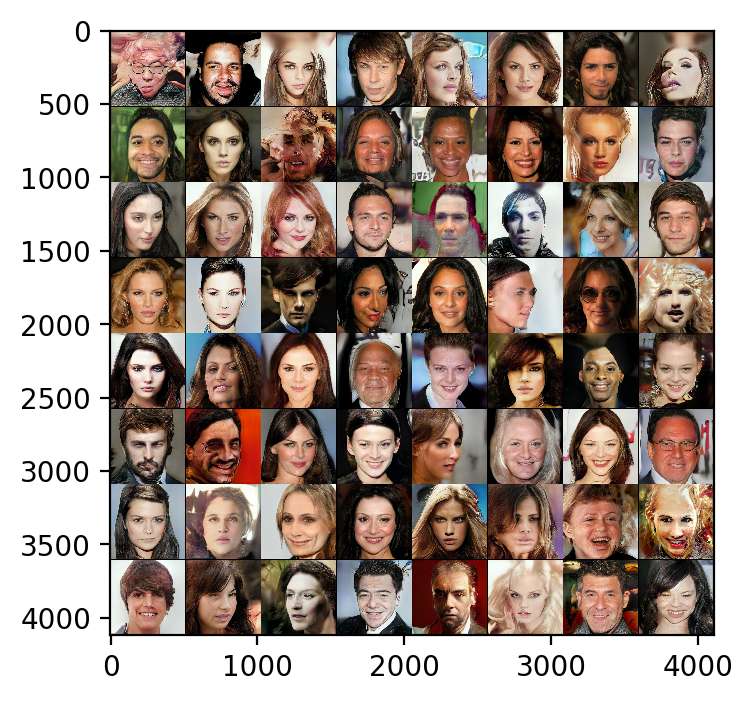

In [7]:
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

## 2. Run Distributed Generation on Spark using TorchNet
This sector will show you how to load pretrained pytorch model to Analytics-Zoo, and run generation in distributed mode.

### Initialize Analytics-Zoo

In [8]:
from zoo.common.nncontext import init_spark_on_local, init_spark_on_yarn
from zoo.pipeline.api.net.torch_net import TorchNet
import numpy as np
import os
hadoop_conf_dir = os.environ.get('HADOOP_CONF_DIR')

if hadoop_conf_dir:
    num_executors = 2
    num_cores_per_executor = 4
    sc = init_spark_on_yarn(
    hadoop_conf=hadoop_conf_dir,
    conda_name="py36", # The name of the created conda-env
    num_executor=num_executors,
    executor_cores=num_cores_per_executor,
    executor_memory="10g",
    driver_memory="2g",
    driver_cores=1)
else:
    num_executors = 1
    num_cores_per_executor = 4
    sc = init_spark_on_local(cores = 4, conf = {"spark.driver.memory": "10g"})

/home/xin/.local/lib/python3.6/site-packages/bigdl/util/engine.py:41: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /opt/spark/latest, and pyspark is found in: /home/xin/.local/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)
/opt/anaconda3/envs/py36/lib/python3.6/site-packages/zoo/util/engine.py:42: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /opt/spark/latest, and pyspark is found in: /home/xin/.local/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, you are recommended to use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)


Prepending /home/xin/.local/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /opt/anaconda3/envs/py36/lib/python3.6/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.8.0-spark_2.4.3-0.6.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Prepending /opt/anaconda3/envs/py36/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
Current pyspark location is : /home/xin/.local/lib/python3.6/site-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
/opt/anaconda3/envs/py36/bin/python


/opt/anaconda3/envs/py36/bin/python

Successfully got a SparkContext


### Construct noise RDD
Parallelize noise samples to spark RDD.

In [9]:
from zoo.common import Sample
noiseSamples = np.vsplit(noise.numpy(), num_images)
noiseRdd = sc.parallelize(noiseSamples).repartition(num_executors * num_cores_per_executor).map(lambda n: Sample.from_ndarray(n.reshape(512), np.zeros(1)))

### Load Generation Network to TorchNet

In [10]:
net = TorchNet.from_pytorch(model.netG, noiseSamples[0].shape)

creating: createTorchNet


### Run Generation in Distributed Mode
Just set distributed to true, the prediction will run on Spark.
The parameter batch_per_thread means how many noise data will be processed once in a thread. The total thread number is your total spark cores.

In [11]:
%%time
global dist_generated_images
dist_result = net.predict(noiseRdd, batch_per_thread=4, distributed=True)
dist_generated_images = dist_result.collect()

CPU times: user 36.5 ms, sys: 16.9 ms, total: 53.3 ms
Wall time: 33.9 s


### Show Image with Matplotlib and Torchvision
As __dist_generated_images__ is a list of ndarray, we need to concate them into a single ndarray.

In [12]:
dist_generated_images = np.stack(dist_generated_images)
dist_grid = torchvision.utils.make_grid(torch.Tensor(dist_generated_images).clamp(min=-1, max=1),
                                        scale_each=True, normalize=True)

The generated images are the same with pytorch's generation

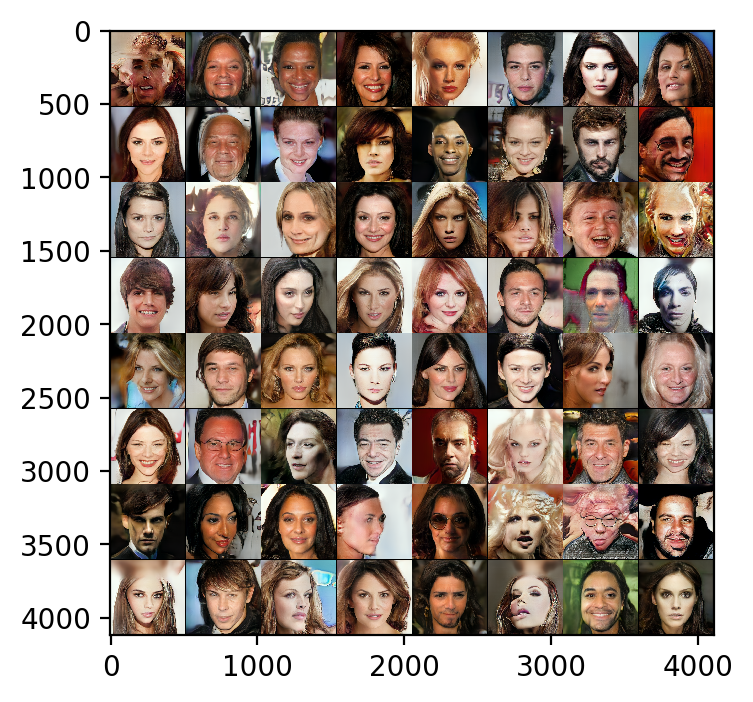

In [13]:
plt.imshow(dist_grid.permute(1, 2, 0).cpu().numpy())
plt.show()